In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

base = "data_max_integration_time/"

UV = "UV/"
VIS = "VIS/"
IR = "IR/"
NO_LED = "NO_LED/"

types = [
    {
        "path": UV,
        "name": "UV"
    },
    {
        "path": VIS,
        "name": "VIS"
    },
    {
        "path": IR,
        "name": "IR"
    },
    {
        "path": NO_LED,
        "name": "NO_LED"
    }
]

channels = ["410nm", "435nm", "460nm", "485nm", "510nm", "535nm", "560nm","585nm","610nm","645nm","680nm","705nm","730nm","760nm","810nm","860nm","900nm","940nm"]

exclude_files = ["19.csv", "13.csv"]

In [9]:
ranges = {}

for type in types:
    
    filepath = base + type["path"]
    files = os.listdir(filepath)
    
    maxes = mins = None
    
    for file in files:
        
        if file in exclude_files:
            continue
        
        with open(filepath + file, "r") as f:
            content = f.readlines()
            entries = content[0:-1]
            glucose_concentration = float(content[-1].replace("glucose_concentration:", "").replace("\n", ""))
            
            value = [np.fromstring(entry.replace("\n", ""), sep="|") for entry in entries]
            value = np.concatenate(value, axis=0).reshape(2, -1).mean(axis=0)
            
            maxes = value if maxes is None else np.maximum(maxes, value)
            mins = value if mins is None else np.minimum(mins, value)
            
    diffs = maxes - mins
    ranges[type["name"]] = np.ceil(np.max(diffs)) / 2
                
print(ranges)

{'UV': 1056.0, 'VIS': 10224.0, 'IR': 6072.5, 'NO_LED': 6.5}


### LED on: UV

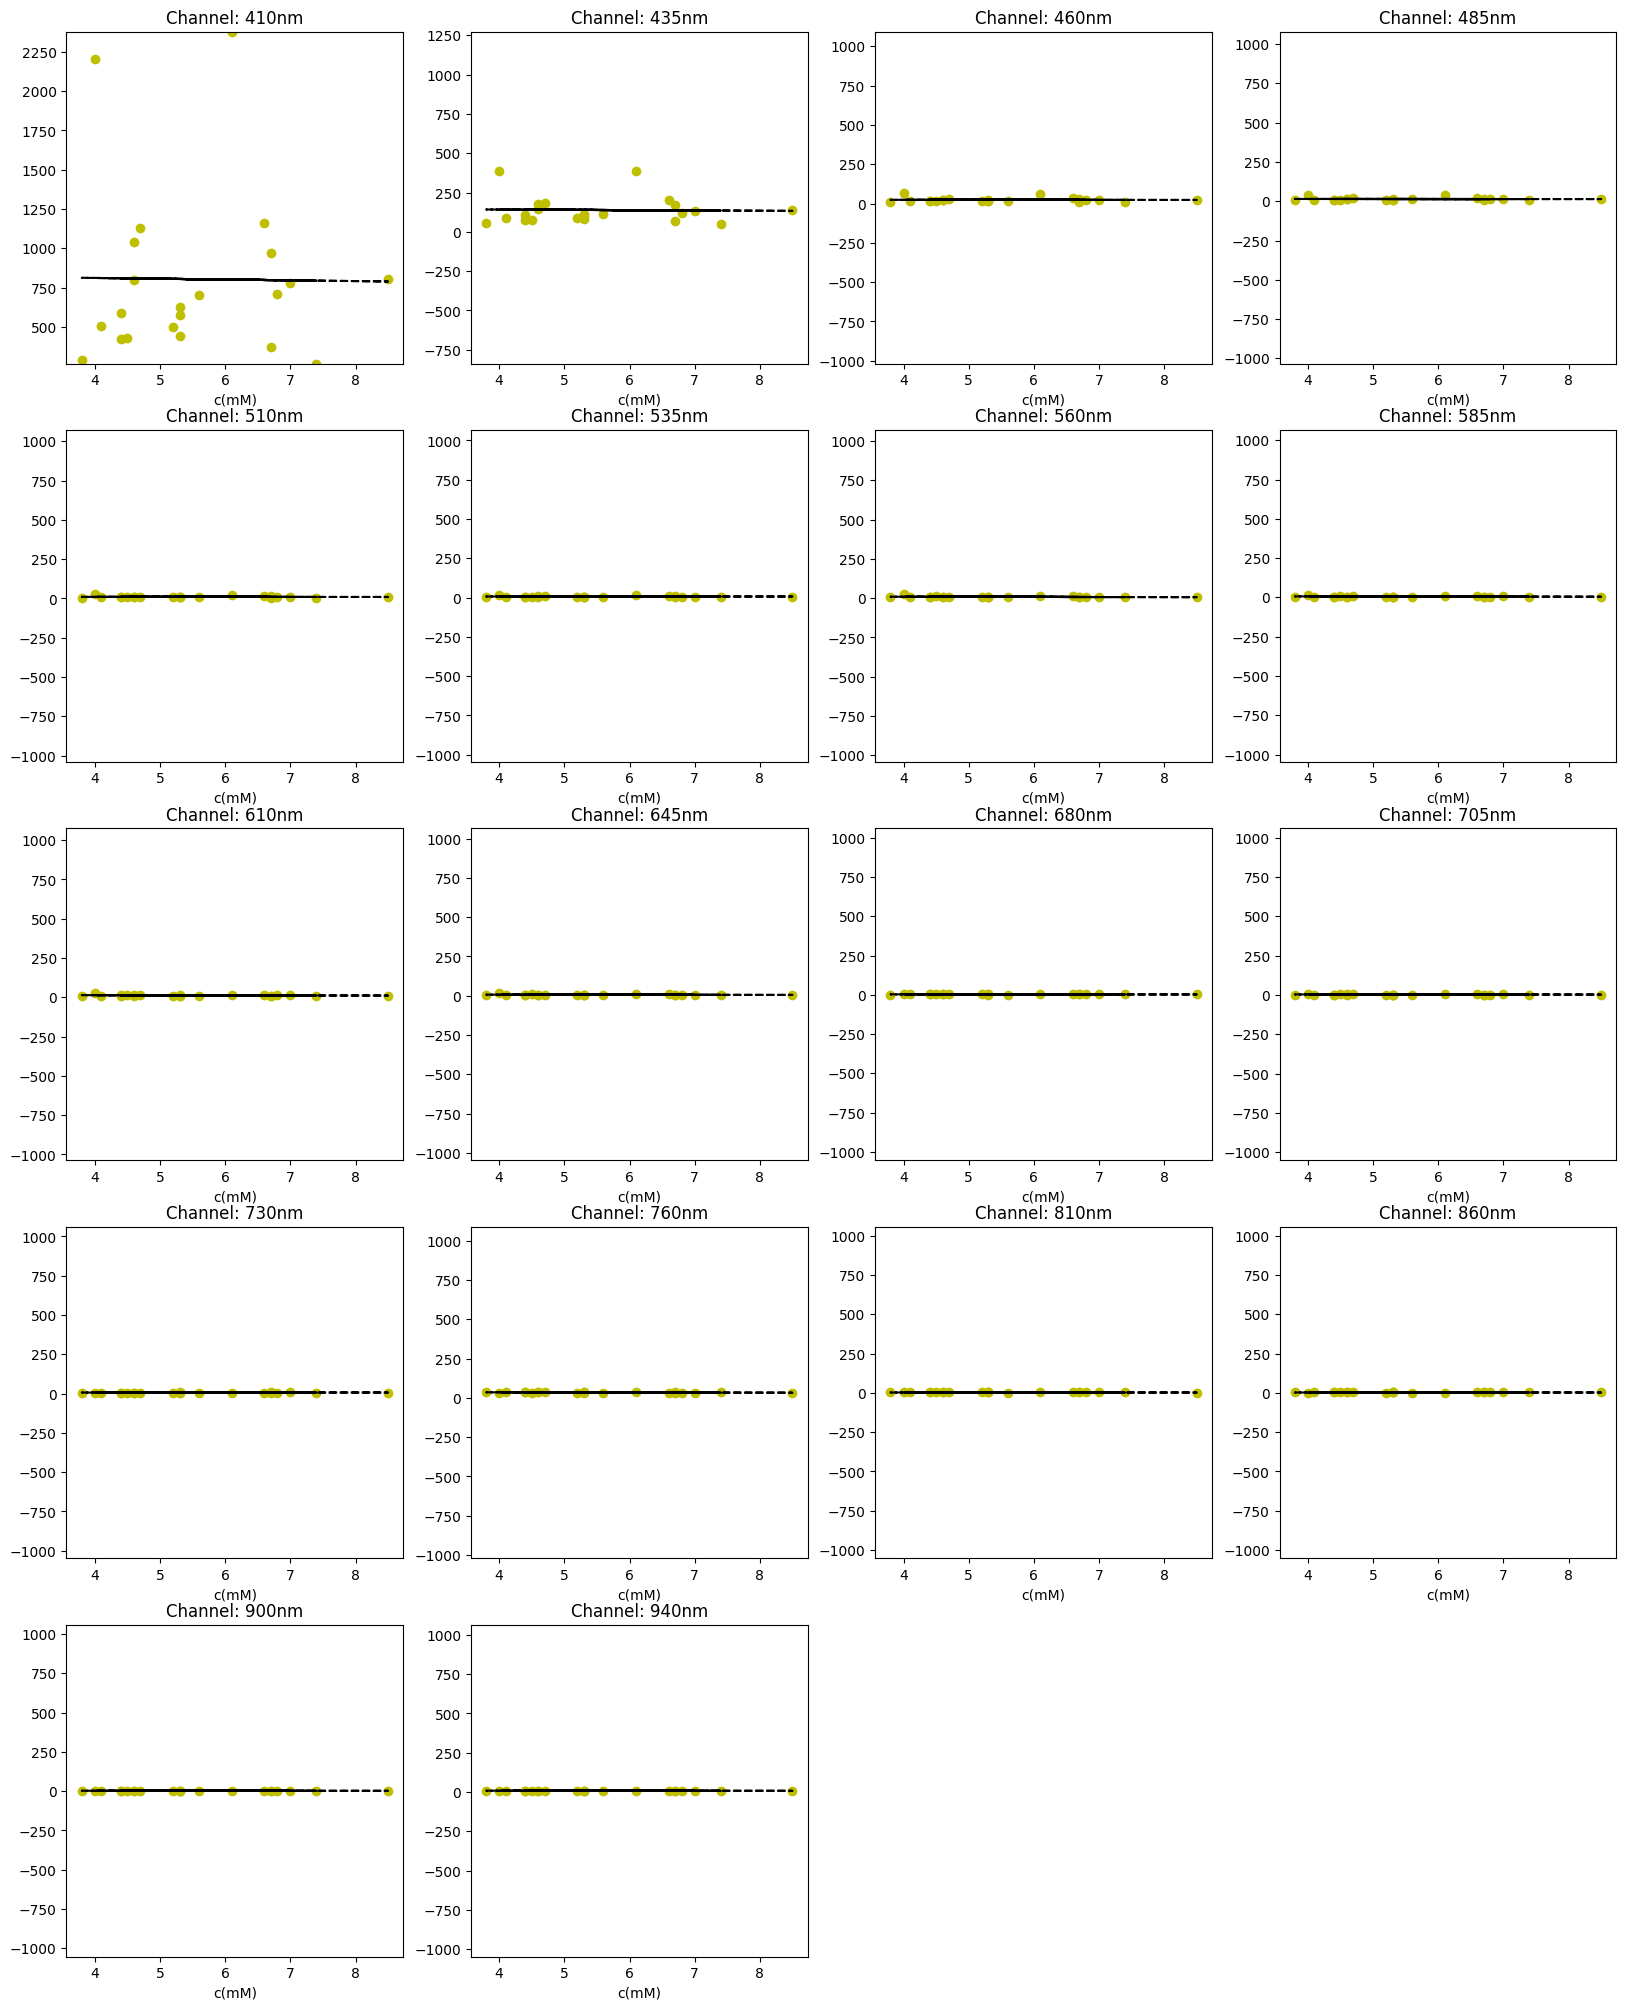

### LED on: VIS

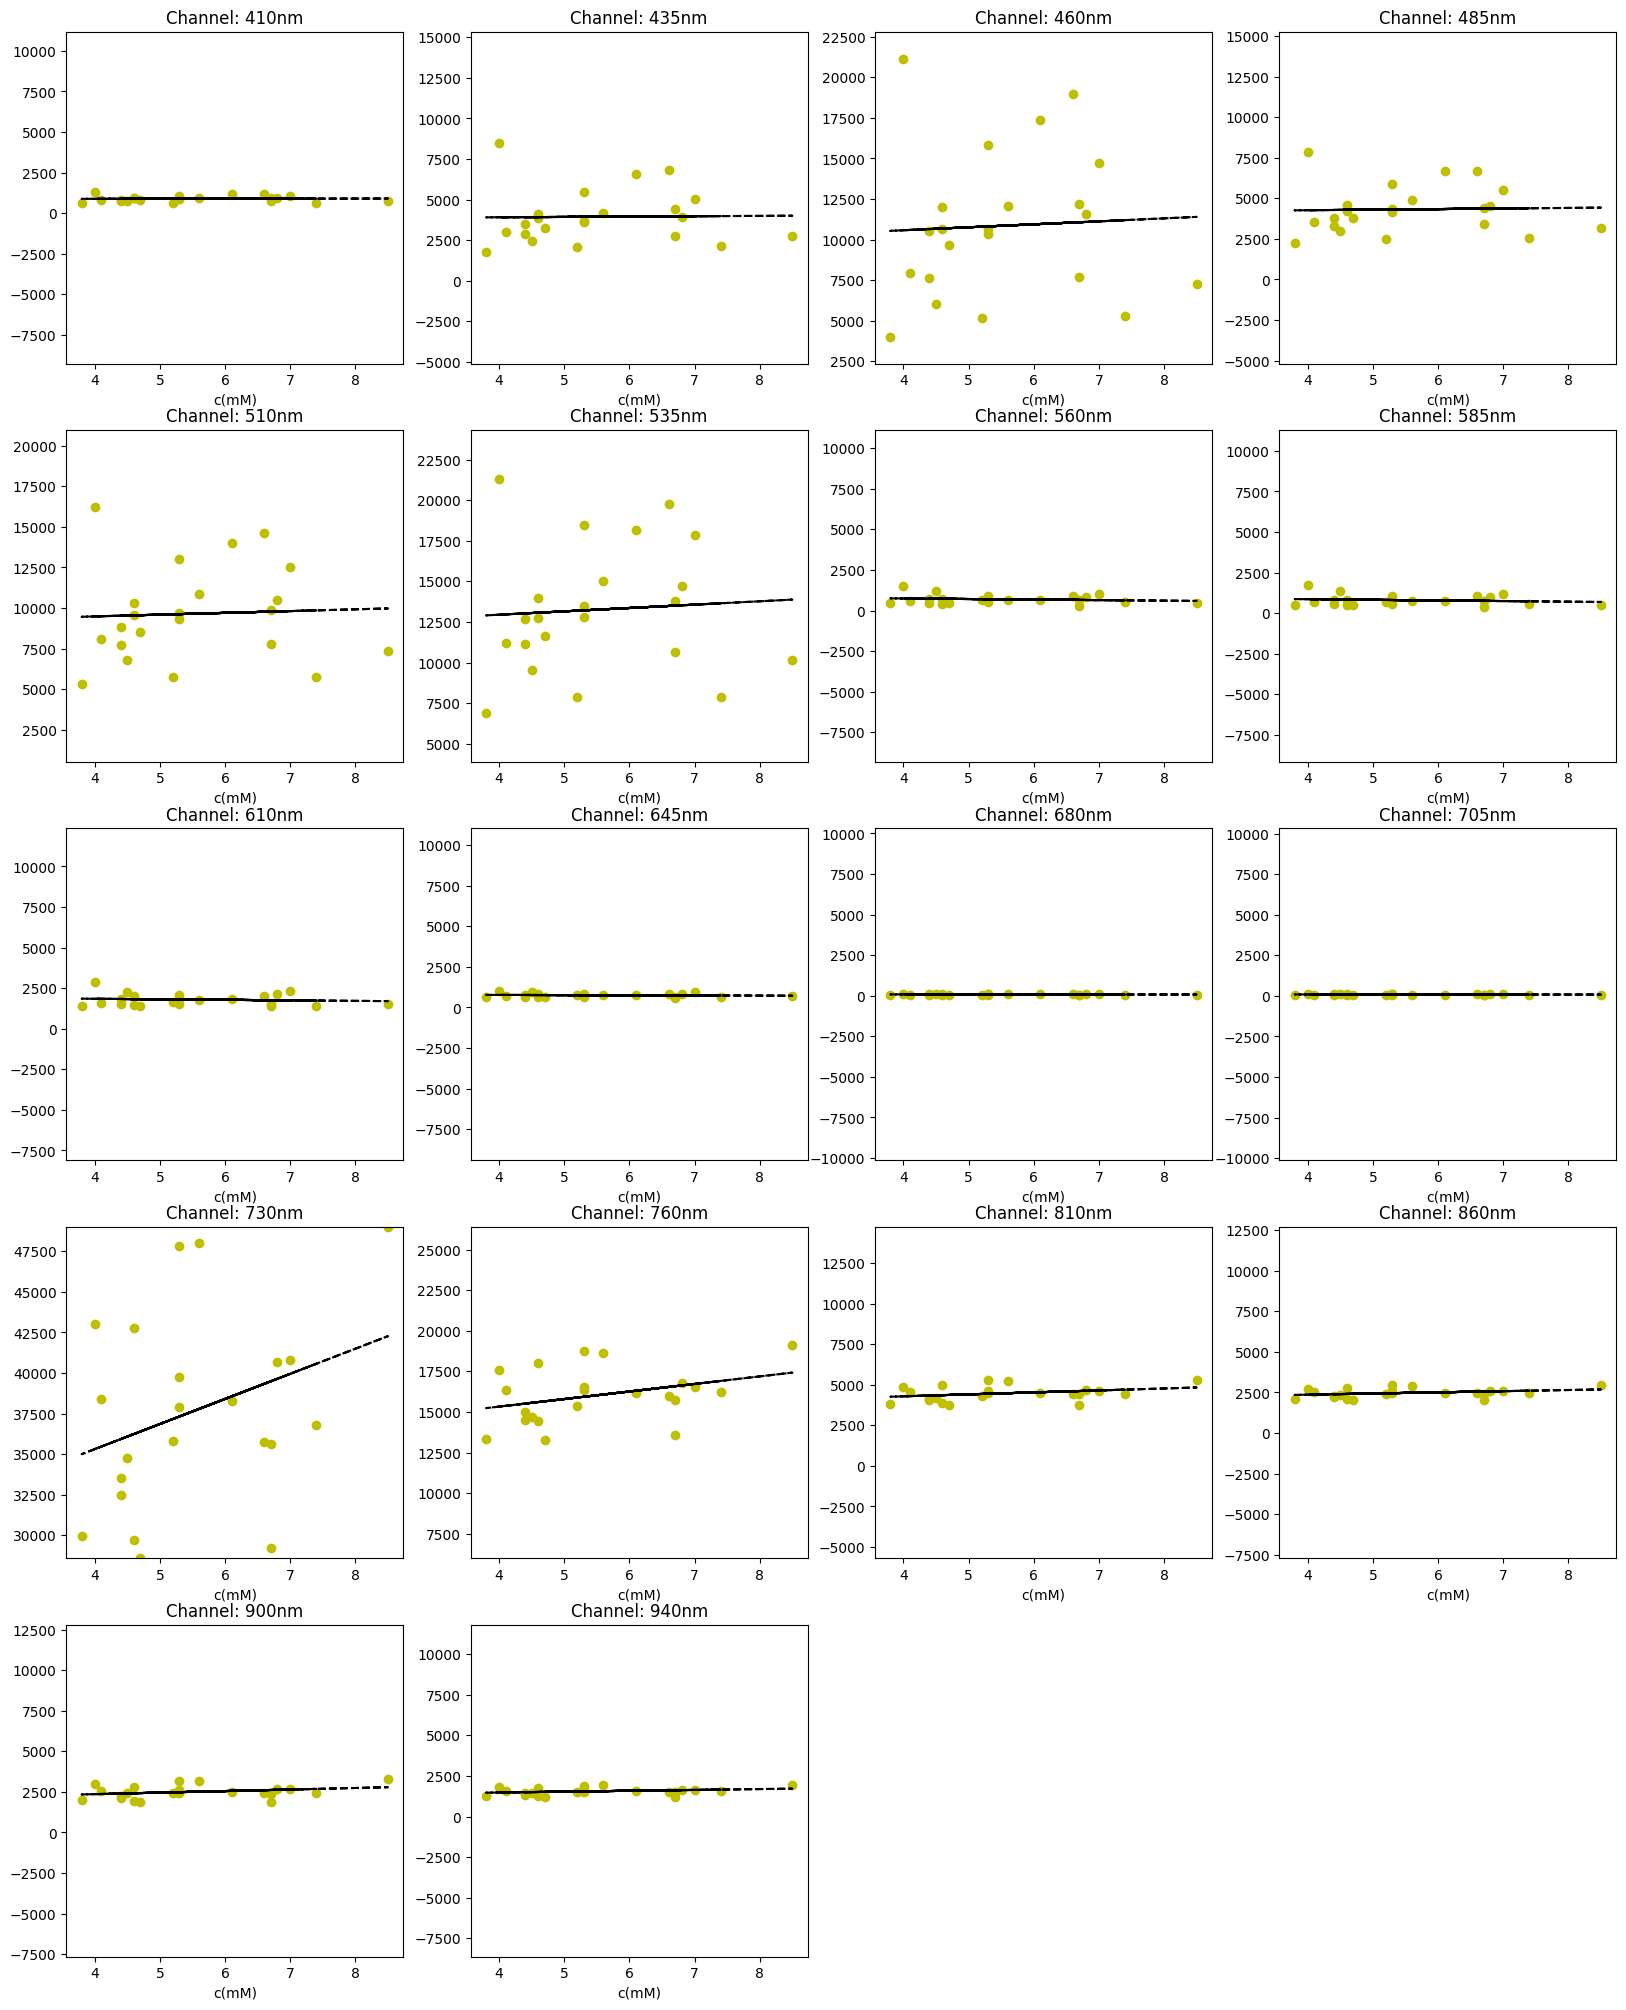

### LED on: IR

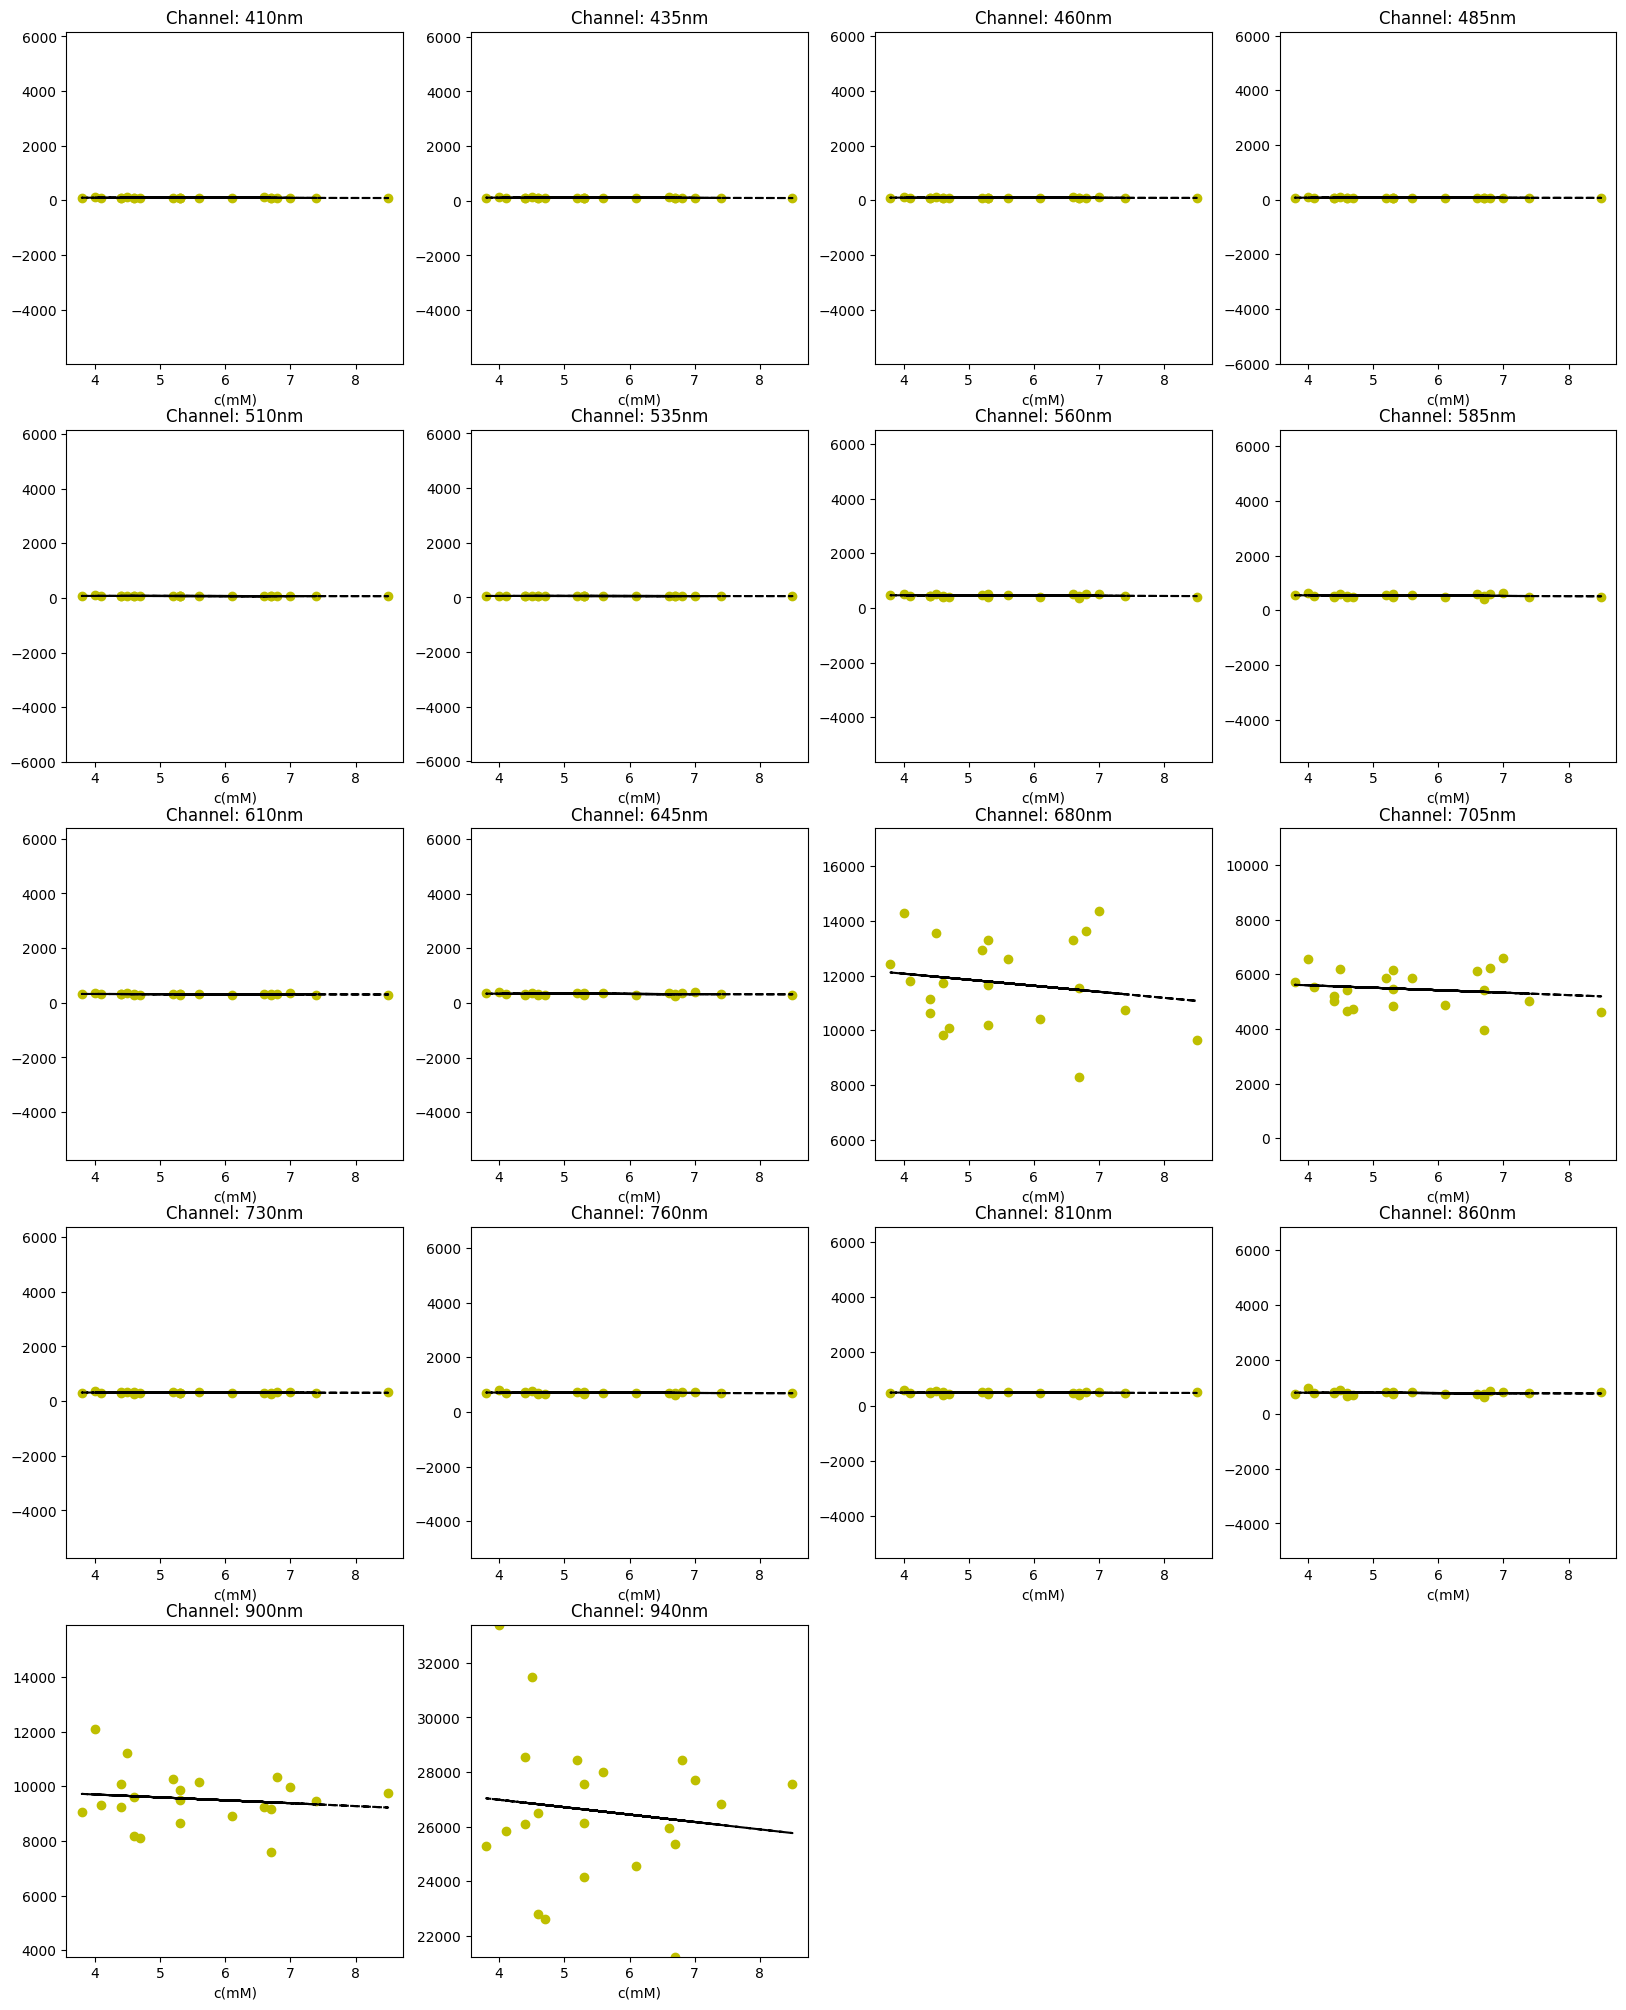

### LED on: NO_LED

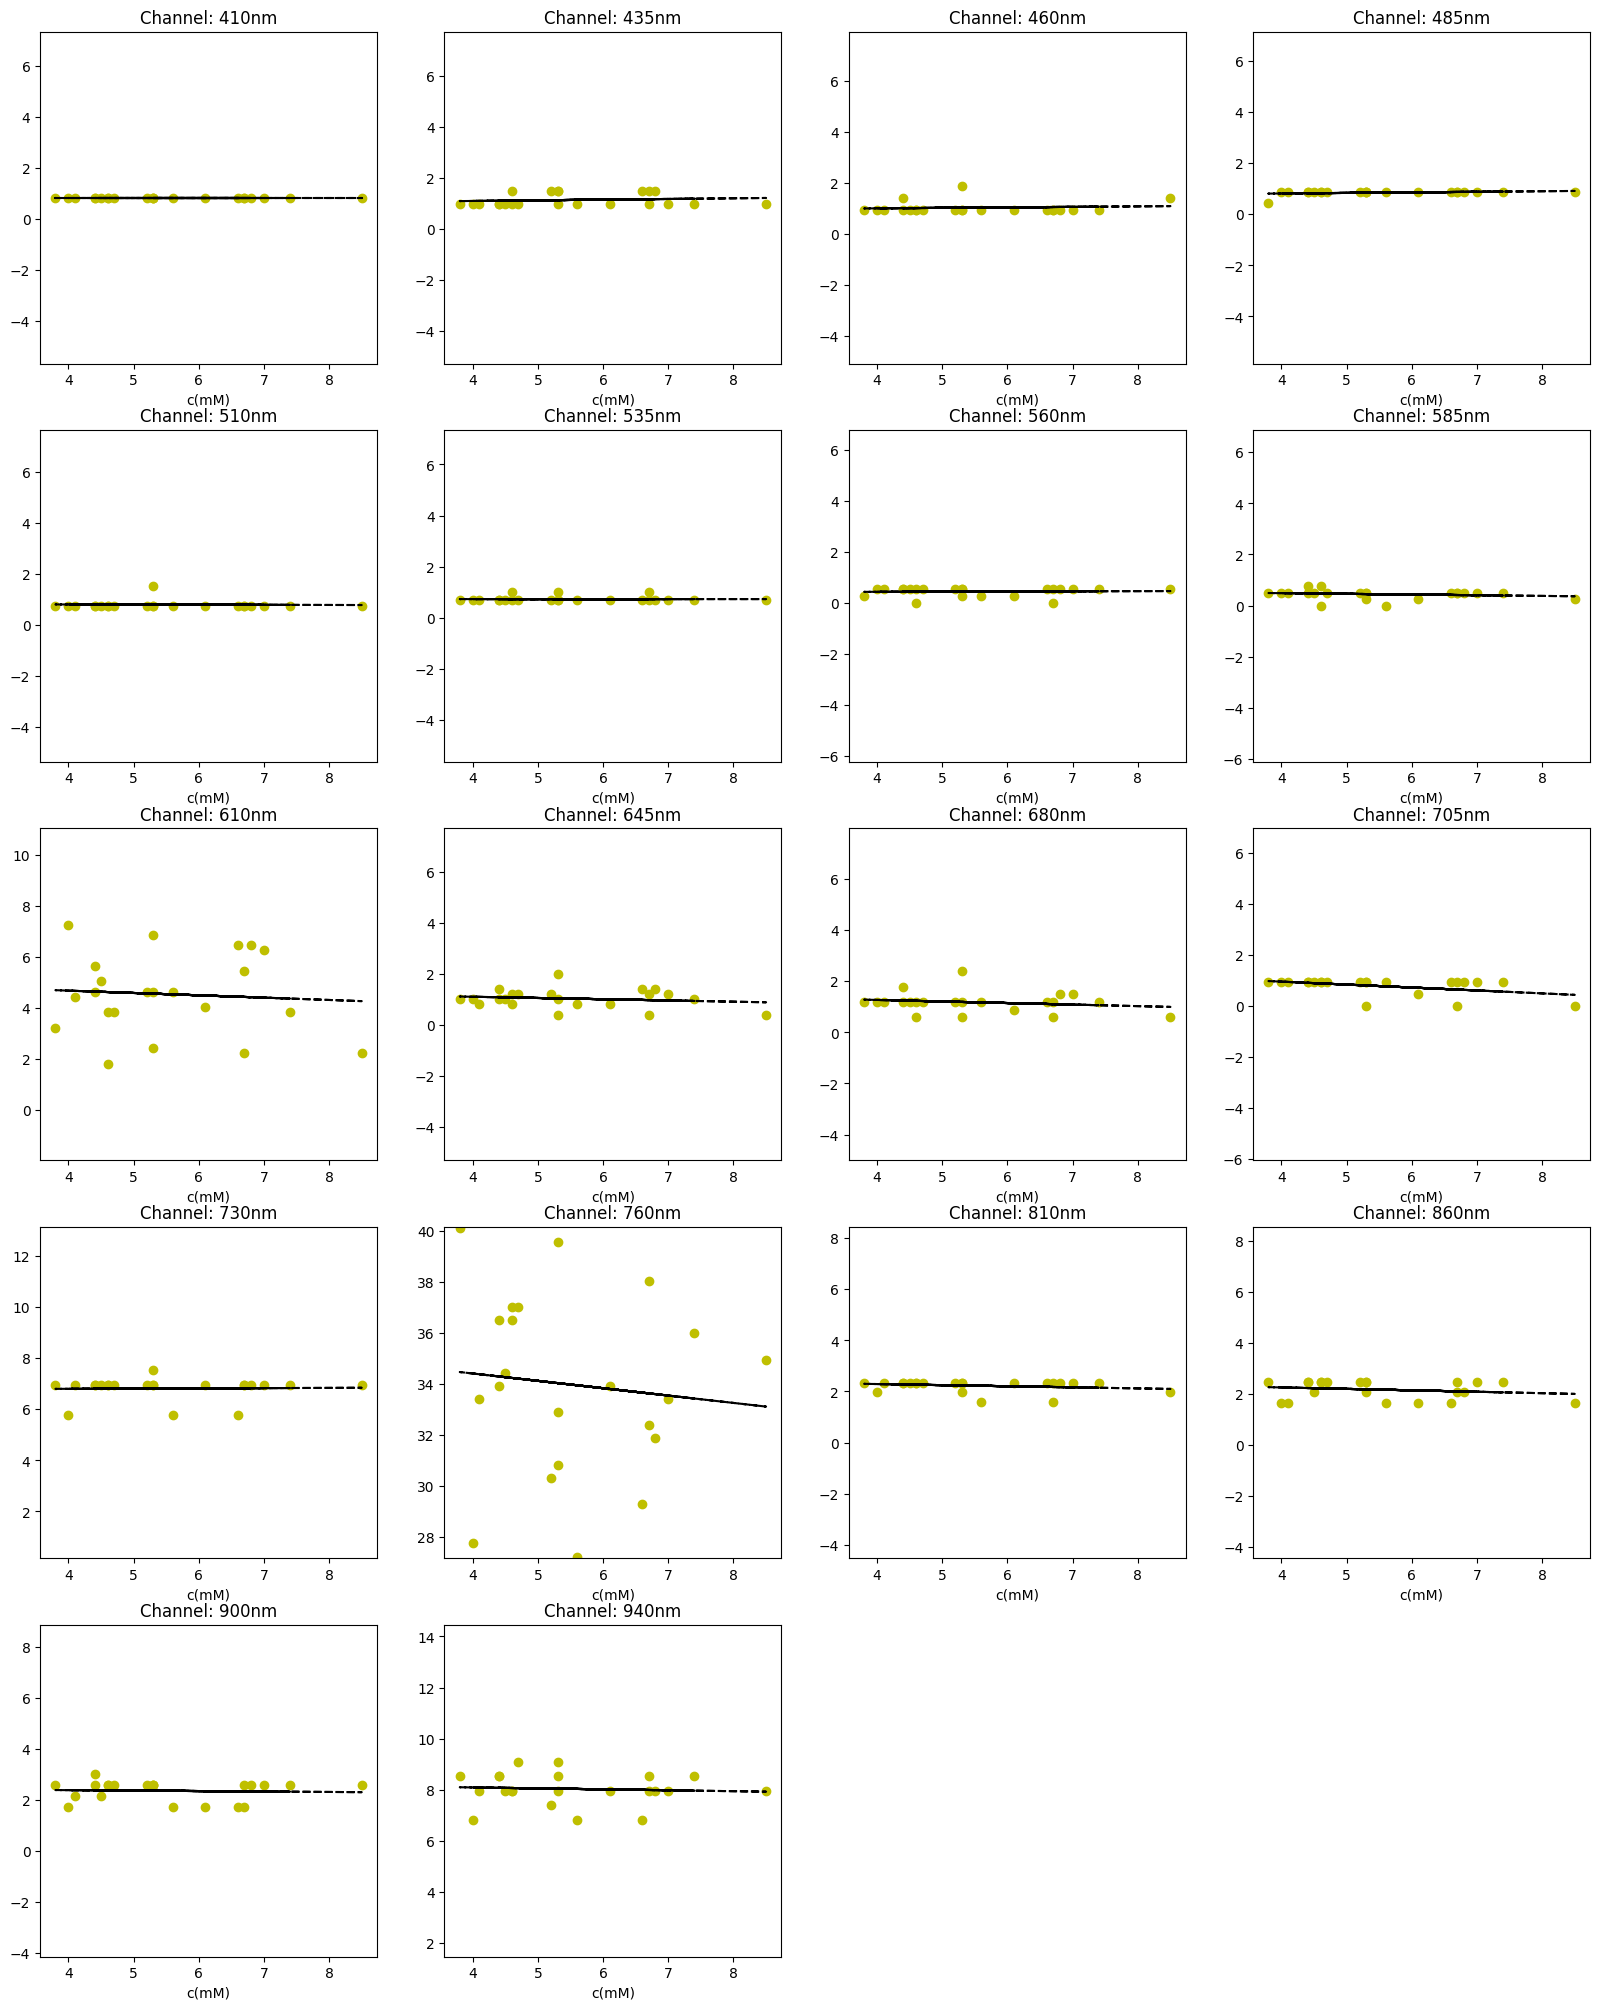

In [12]:
for type in types:
    display(Markdown(f"### LED on: {type['name']}"))
    
    filepath = base + type["path"]
    files = os.listdir(filepath)
    
    x = y = None
    maxes = mins = None    
    
    linreg = [[[], []] for _ in range(len(channels))]
    
    for file in files:
        
        if file in exclude_files:
            continue
        
        with open(filepath + file, "r") as f:
            content = f.readlines()
            entries = content[0:-1]
            glucose_concentration = float(content[-1].replace("glucose_concentration:", "").replace("\n", ""))
            
            value = [np.fromstring(entry.replace("\n", ""), sep="|") for entry in entries]
            value = np.concatenate(value, axis=0).reshape(2, -1).mean(axis=0)
            
            x = np.array([glucose_concentration]) if x is None else np.append(x, glucose_concentration)
            y = value if y is None else np.vstack((y, value))
            
            maxes = value if maxes is None else np.maximum(maxes, value)
            mins = value if mins is None else np.minimum(mins, value)
            
    plt.figure(figsize=(20, 25))
    
    for ix, channel in enumerate(channels):
        
        plt.subplot(5, 4, ix + 1)
        plt.title(f"Channel: {channels[ix]}")
        plt.xlabel("c(mM)")
        
        mean = maxes[ix] - (maxes[ix] - mins[ix]) / 2
        plt.ylim(mean - ranges[type["name"]], mean + ranges[type["name"]])
        
        plt.plot(x, y[:, ix], 'yo')
        
        linreg[ix][0] = x
        linreg[ix][1] = y[:, ix]
        
    for ix in range(len(channels)):
        x = linreg[ix][0]
        y = linreg[ix][1]
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef) 
        plt.subplot(5, 4, ix + 1)
        plt.plot(x, poly1d_fn(x), '--k')
            
    plt.show()